In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

In [4]:
# Configure Git
!git config --global user.email "idantsri2007@gmail.com"
!git config --global user.name "SILETRO"

In [5]:
!git clone https://{token}@github.com/SILETRO/Cryptonite-RTP-Idant.git
%cd Cryptonite-RTP-Idant

Cloning into 'Cryptonite-RTP-Idant'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 61 (delta 16), reused 49 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 1019.33 KiB | 8.49 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/Cryptonite-RTP-Idant


In [6]:
%cd /content/Cryptonite-RTP-Idant/

/content/Cryptonite-RTP-Idant/Task-3


In [12]:
!cp '/content/drive/MyDrive/Colab Notebooks/MLP_From_Scratch.ipynb' Task-3/

cp: cannot create regular file 'Task-3/': Not a directory


In [10]:
!git add .

In [11]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
wine_quality = fetch_ucirepo(id=186)
x = wine_quality.data.features
y = wine_quality.data.targets
data_w = pd.read_csv('/content/winequality-white.csv',delimiter=';')
data_r = pd.read_csv('/content/winequality-red.csv',delimiter=';')

### EDA and Preprocessing

In [195]:
X.sample(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1471,6.7,0.700,0.08,3.75,0.067,8.0,16.0,0.99334,3.43,0.52,12.6
2409,6.0,0.280,0.49,6.80,0.048,61.0,222.0,0.99530,3.19,0.47,9.3
223,8.6,0.645,0.25,2.00,0.083,8.0,28.0,0.99815,3.28,0.60,10.0
4459,7.3,0.210,0.33,1.00,0.037,66.0,144.0,0.99230,3.11,0.52,10.2
3362,7.3,0.210,0.30,10.90,0.037,18.0,112.0,0.99700,3.40,0.50,9.6


In [196]:
x.isnull().sum()

,0
fixed_acidity,0
volatile_acidity,0
citric_acid,0
residual_sugar,0
chlorides,0
free_sulfur_dioxide,0
total_sulfur_dioxide,0
density,0
pH,0
sulphates,0


<Axes: >

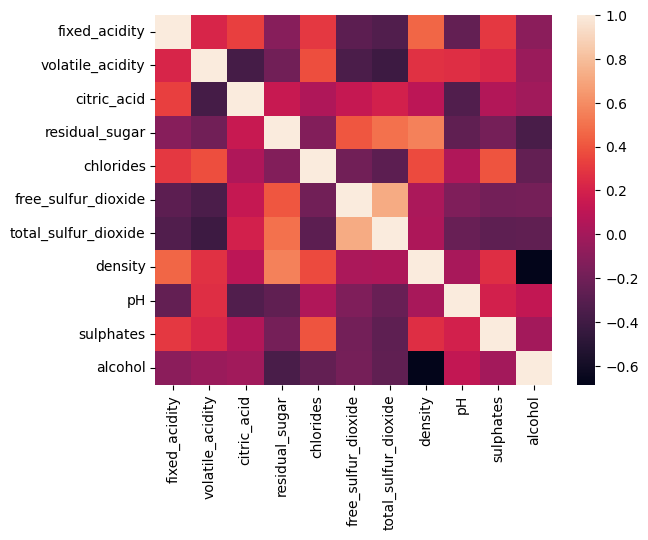

In [197]:
import seaborn as sns
sns.heatmap(x.corr())

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [199]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [200]:
cols = X_train.columns.tolist()

In [201]:
pipeline = Pipeline([
                    ("scaler",StandardScaler())])
preprocess_pipeline = ColumnTransformer([("num",pipeline,cols)])

In [202]:
X_train_processed = preprocess_pipeline.fit_transform(X_train)
X_test_processed = preprocess_pipeline.transform(X_test)

In [203]:
def prepare_wine_data(y, min_quality):
    # Shift labels to start from 0
    y = np.asarray(y).reshape(-1)
    Y_encoded = (y - min_quality)
    return Y_encoded.reshape(-1,1)

In [204]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### Building the Neural Network

In [205]:
np.random.seed(42)

In [206]:
def initialize_parameters(layer_dims):  #array of number of neurons in hidden layers
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L): #He initialization
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2.0 / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    return parameters

In [207]:
def relu(Z):
  A = np.maximum(0, Z)
  cache = Z
  return A, cache

In [208]:
def softmax(Z):
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shift)
    A = expZ / np.sum(expZ, axis=0, keepdims=True)
    cache = Z  # not strictly necessary
    return A, cache

In [209]:
def linear_forward(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  return Z, cache

In [210]:
def linear_activation_forward(A_prev, W, b, activation):
  Z, linear_cache = linear_forward(A_prev, W, b)

  if activation == "softmax":
    A, activation_cache = softmax(Z)

  elif activation == "relu":
    A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache)
  return A, cache

In [211]:
def L_model_forward(X, parameters, hidden_activation="relu"):
  caches = []
  A = X #initial A is X only
  L = len(parameters) // 2  #divide by 2 because parameters contain both weights and bias term

  for l in range(1, L):
    A_prev = A
    A, cache = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'],hidden_activation)
    caches.append(cache)

  AL, cache = linear_activation_forward(A,parameters[f'W{L}'],parameters[f'b{L}'],"softmax")
  caches.append(cache)

  return AL, caches

In [212]:
def compute_cost(AL, Y):  #sparse cross-entropy
  m = Y.shape[0]
  AL = np.clip(AL, 1e-12, 1 - 1e-12)  # Prevent log(0)
  correct_probs = AL[Y, np.arange(m)]
  cost = -np.sum(np.log(correct_probs)) / m
  return cost

In [213]:
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = 1/m* np.dot(dZ, A_prev.T)
  db = 1/m* np.sum(dZ, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dZ)

  return dA_prev, dW, db

In [214]:
def relu_grad(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  return dZ

In [215]:
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache

  if activation == "relu":
    dZ = relu_grad(dA, activation_cache)

  dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db

In [216]:
def L_model_backward(AL, Y, caches, hidden_activation="relu"):
  grads = {}
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(-1)

  # Initialize backpropagation
  dAL = AL.copy()
  dAL[Y, np.arange(m)] -= 1

  # Output layer is softmax
  linear_cache_L, _ = caches[L-1]
  dA_prev_L, dW_L, db_L = linear_backward(dAL, linear_cache_L)
  grads[f"dW{L}"] = dW_L
  grads[f"db{L}"] = db_L
  grads[f"dA{L-1}"] = dA_prev_L
  # Hidden layers

  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
    grads[f"dA{l+1}"], current_cache, hidden_activation)
    grads[f"dA{l}"] = dA_prev_temp
    grads[f"dW{l+1}"] = dW_temp
    grads[f"db{l+1}"] = db_temp

  return grads

In [217]:
def update_parameters(parameters, grads, learning_rate):

  L = len(parameters) // 2

  for l in range(1, L + 1):
    parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate * grads[f"dW{l}"]
    parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate * grads[f"db{l}"]

  return parameters

In [218]:
def train_model(X, Y, layer_dims, learning_rate=0.01, num_iterations=30000, hidden_activation="relu"):
  np.random.seed(42)
  costs = []
  # Initialize parameters
  parameters = initialize_parameters(layer_dims)

  # Training loop
  for i in range(num_iterations):
    # Forward propagation
    AL, caches = L_model_forward(X, parameters, hidden_activation)

    # Compute cost
    cost = compute_cost(AL, Y)
    costs.append(cost)

    # Backward propagation
    grads = L_model_backward(AL, Y, caches, hidden_activation)

    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)

  return parameters,costs


In [219]:
def predict(X, parameters, hidden_activation="relu"):

  AL, caches = L_model_forward(X, parameters, hidden_activation)
  predictions = np.argmax(AL, axis=0).astype(int)

  return predictions

In [220]:
weights,costs = train_model(X_train_processed.T,y_train_encoded.T,[X_train_processed.shape[1],64,32,16,7])

In [221]:
predictions = predict(X_test_processed.T, weights).reshape(-1,1)
y_test_classes = y_test_encoded.reshape(-1,1)

In [222]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [223]:
accuracy_score(y_test_classes, predictions)

0.5723076923076923

In [224]:
precision_score(y_test_classes, predictions,average='weighted')

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5526281581584876

In [225]:
recall_score(y_test_classes, predictions,average='weighted')

0.5723076923076923

In [226]:
f1_score(y_test_classes, predictions,average='weighted')

0.5587137109813959

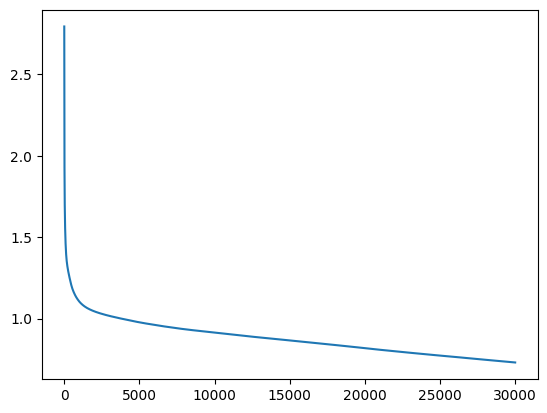

In [227]:
plt.plot(costs)